In [2]:
! pip install umap-learn

     |████████████████████████████████| 69 kB 11.0 MB/s eta 0:00:01
  Created wheel for umap-learn: filename=umap_learn-0.4.6-py3-none-any.whl size=67950 sha256=9430c98c79bb817eb8eb170c7d9dfbf435bfa66ee8e1ff36b7963a801f9d6b9e
  Stored in directory: /home/ubuntu/.cache/pip/wheels/14/9a/ed/66159a5e13d3b6341b6542cf4f1faf478834753bed5ecaef8d
Successfully built umap-learn


In [2]:
#imports:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import umap
import numba.targets
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [4]:
class sleep_clustering:

    def load_data(self,df,label_df,train_ids,test_id):
        self.train = np.zeros((1,121)) 
        sessionNames_list = df.index.levels[0]
        for i in train_ids:
            idx=i
            sessionName = sessionNames_list[idx]
            samples = filter_by(df,{'sessionName' : [sessionName]})
            samples = samples.to_numpy()
            self.train = np.concatenate((self.train,samples),axis=0)
        idx=test_id
        sessionName = sessionNames_list[idx]
        self.test = filter_by(df,{'sessionName' : [sessionName]}).to_numpy()
        label = filter_by(label_df,{'sessionName' : [sessionName]}).reset_index()
        self.labels = label.y
        self.labels.replace(['U','W','R','N2','N3'],[-1,3,2,1,0])
        self.labels_ts = labels.timestamp
    
    
    def fit(self, params):
        pca_components = params[0]
        remove_pc = params[1]
        umap_min_dist = params[2]
        umap_n_neighbors = params[3]
        umap_n_components = params[4]
        umap_low_memory = params[5]
        dbscan_eps = params[6]
        dbscan_min_samples = params[7]
        random_state = params[8];
        
        self.pca = PCA(n_components=pca_components)
        self.umap_reducer = umap.UMAP(n_neighbors=umap_n_neighbors,
                                 min_dist=umap_min_dist,
                                 n_components=umap_n_components,
                                 random_state=random_state,
                                 low_memory=umap_low_memory,
                                 verbose=True)
        self.db = DBSCAN(eps=dbscan_eps,min_samples=dbscan_min_samples)
                                   
        if pca_components>0:
            S1 = self.pca.fit_transform(self.train)
        else:
            S1 = self.train
        if remove_pc:
            S2 = S1[:,1:]
        else:
            S2 = S1                      
        
        self.S3 = self.umap_reducer.fit_transform(S2)                           
        self.S4 = self.db.fit(self.S3)
    
    def predict(self,test,params):
        pca_components = params[0]
        remove_pc = params[1]
        if pca_components>0:
            S1 = self.pca.transform(test)
        else:
            S1 = test
        if remove_pc:
            S2 = S1[:,1:]
        else:
            S2 = S1                      
        
        S3 = self.umap_reducer.transform(S2)                           
        S4 = self.db.fit(S3)
        return S4.labels_
    
    def transform(self,test,params):
        pca_components = params[0]
        remove_pc = params[1]
        if pca_components>0:
            S1 = self.pca.transform(test)
        else:
            S1 = test
        if remove_pc:
            S2 = S1[:,1:]
        else:
            S2 = S1                      
        
        S3 = self.umap_reducer.transform(S2)                           
        return S3                         
        
    def plot_projection(self, projection, colors=None):
        #if colors==None:
        #    colors=1;
        plt.figure(figsize=(15,5))
        plt.scatter(projection[:, 0], projection[:, 1],c=colors,s=3)
        plt.gca().set_aspect('equal', 'datalim')
        plt.legend(colors)

    def plot_heatmap(self,data):
        plt.figure(figsize=(15,5))
        ax = sns.heatmap(data.T,cmap='jet',cbar=False) #,vmin=-5,vmax=5)

    def plot_hypnogram(self,labels,timestamp=None):
        #for i in np.arange(len(labels)):
        #    if labels[i]==-1:
        #        labels[i] = labels[i-1]
        smoothed = np.zeros((len(labels),1))
        for i in np.arange(15,len(labels)-15):
            smoothed[i] = stats.mode(labels[i-15:i+14])[0]
        if timestamp==None:
            timestamp=np.arange(len(labels))
        plt.figure(figsize=(15,5))
        plt.plot(timestamp,smoothed)
        plt.xlabel('Time')
        plt.ylabel('Class')
        plt.title('Hypnogram')

        
def filter_by(df, constraints):
    """Filter MultiIndex by sublevels."""
    indexer = [constraints[name] if name in constraints else slice(None)
               for name in df.index.names]
    return df.loc[tuple(indexer)] if len(df.shape) == 1 else df.loc[tuple(indexer),]

# Semi-supervised UMAP

In [3]:
# Initialize - uses data stored on AWS S3 
import boto3

bucket_name = 'mlflow-sleep'
INPUT_DIR = 'data'

cred = boto3.Session().get_credentials()
ACCESS_KEY = cred.access_key
SECRET_KEY = cred.secret_key

s3 = boto3.resource('s3', region_name='us-east-1')
bucket = s3.Bucket(bucket_name)

s3client = boto3.client('s3', 
            aws_access_key_id = ACCESS_KEY, 
            aws_secret_access_key = SECRET_KEY
           )

In [5]:
# map file locations
data_key='data/df_features_test_env_labeled.pkl'
label_key='data/df_labels_test_env.pkl'
unlabeled_key = 'data/df_features_test_env_unlabeled.pkl'
data_location = 's3://{}/{}'.format(bucket_name, data_key)
df=pd.read_pickle(data_location)
label_location = 's3://{}/{}'.format(bucket_name, label_key)
label_df = pd.read_pickle(label_location)
unlabeled_location = 's3://{}/{}'.format(bucket_name, unlabeled_key)
unlabeled_df = pd.read_pickle(unlabeled_location)

In [10]:
#Collect training data - labeled
#data loading is a bit slow - splits each recording into half-overlapping 30 second windows 

sessionNames_list = df.index.levels[0]
window_size=30
x_data = np.empty((0, window_size, 121), int)
y_data = np.empty((0, 1), int)
train_ids = [1,2,3,4,5]
for idx in train_ids:
   
    sessionName = sessionNames_list[idx]
    print(f"sessionName:{sessionName}", end =" ") 

    samples = filter_by(df,{'sessionName' : [sessionName]})
    timestamp = samples.reset_index().timestamp
    samples = samples.to_numpy()
    samples = pd.DataFrame(data=samples,index=timestamp)

    print(f"data:{samples.shape}", end =" ") 
    

    labels = filter_by(label_df,{'sessionName' : [sessionName]}).reset_index()
    hypno = labels.y
    hypno_ts = labels.timestamp
    hypno.index = list(labels.timestamp)

    hypno_val = hypno.replace(['U','W','R','N2','N3'],[-1,3,2,1,0])
   
    print(f"hypno_val:{len(hypno_val)}")

    start = np.round((hypno_ts[0]-timestamp[0])/(window_size*1000)).astype(int)
    if (start>0):    
        samples=samples[start:]
        
    if (samples.shape[0]/window_size!=0):
        end = int(samples.shape[0]/window_size)*window_size
        samples=samples[:end]
        
    samples = samples.to_numpy()
    yc = 0
    for t in range(start+15,end-15,15):
        sample = samples[t-15:t+15,:]
        sample=np.expand_dims(sample,axis=0)
        x_data = np.vstack((x_data,sample))
        y_data = np.vstack((y_data,hypno_val.to_numpy()[yc]))
        yc +=1
    

sessionName:2019-07-17-21-39-40 data:(16621, 121) hypno_val:1107
sessionName:2019-07-22-19-34-39 data:(29394, 121) hypno_val:1958
sessionName:2019-07-22-19-58-50 data:(14767, 121) hypno_val:983
sessionName:2019-07-22-20-10-03 data:(16984, 121) hypno_val:1131
sessionName:2019-07-23-19-32-23 data:(31603, 121) hypno_val:2105


In [11]:
# check dimensions
print(x_data.shape)
print(y_data.shape)

(7278, 30, 121)
(7278, 1)


In [12]:
#Collect training data - unlabeled
#unlabeld data is split the same way, all labels are set to -1
window_size=30
sessionNames_list = unlabeled_df.index.levels[0]
train_ids = [0,1,2,3,4,5,6]
for idx in train_ids:
   
    sessionName = sessionNames_list[idx]
    print(f"sessionName:{sessionName}", end =" ") 

    samples = filter_by(unlabeled_df,{'sessionName' : [sessionName]})
    timestamp = samples.reset_index().timestamp
    samples = samples.to_numpy()
    samples = pd.DataFrame(data=samples,index=timestamp)

    print(f"data:{samples.shape}") 
    
    start = 0
    if (start>0):    
        samples=samples[start:]
        
    if (samples.shape[0]/window_size!=0):
        end = int(samples.shape[0]/window_size)*window_size
        samples=samples[:end]
        
    samples = samples.to_numpy()
    yc = 0
    for t in range(start+15,end-15,15):
        sample = samples[t-15:t+15,:]
        sample=np.expand_dims(sample,axis=0)
        x_data = np.vstack((x_data,sample))
        y_data = np.vstack((y_data,-1))
        yc +=1

sessionName:2019-08-17-19-17-01 data:(29650, 121)
sessionName:2019-08-17-22-49-11 data:(17148, 121)
sessionName:2019-08-18-20-07-11 data:(26051, 121)
sessionName:2019-08-18-20-38-22 data:(23084, 121)
sessionName:2019-08-19-20-44-45 data:(27619, 121)
sessionName:2019-08-22-19-16-00 data:(32734, 121)
sessionName:2019-08-27-20-56-05 data:(23778, 121)


In [13]:
# check dimensions
print(x_data.shape)
print(y_data.shape)

(19262, 30, 121)
(19262, 1)


In [43]:
#collect test data - set test_id to a session not in the training data
sessionNames_list = df.index.levels[0]
x_test = np.empty((0, window_size, 121), int)
y_test = np.empty((0, 1), int)
test_id=[0]
for idx in test_id:
   
    sessionName = sessionNames_list[idx]
    print(f"sessionName:{sessionName}", end =" ") 

    samples = filter_by(df,{'sessionName' : [sessionName]})
    timestamp = samples.reset_index().timestamp
    samples = samples.to_numpy()
    samples = pd.DataFrame(data=samples,index=timestamp)

    print(f"data:{samples.shape}", end =" ") 
    

    labels = filter_by(label_df,{'sessionName' : [sessionName]}).reset_index()
    hypno = labels.y
    hypno_ts = labels.timestamp
    hypno.index = list(labels.timestamp)

    hypno_val = hypno.replace(['U','W','R','N2','N3'],[-1,3,2,1,0])
   
    print(f"hypno_val:{len(hypno_val)}")

    start = np.round((hypno_ts[0]-timestamp[0])/(window_size*1000)).astype(int)
    if (start>0):    
        samples=samples[start:]
        
    if (samples.shape[0]/window_size!=0):
        end = int(samples.shape[0]/window_size)*window_size
        samples=samples[:end]
        
    samples = samples.to_numpy()
    yc = 0
    for t in range(start+15,end-15,15):
        sample = samples[t-15:t+15,:]
        sample=np.expand_dims(sample,axis=0)
        x_test = np.vstack((x_test,sample))
        y_test = np.vstack((y_test,hypno_val.to_numpy()[yc]))
        yc +=1

sessionName:2019-07-17-21-39-40 data:(16621, 121) hypno_val:1107


In [44]:
x_test.shape

(1106, 30, 121)

In [145]:
#training parameters (current were the best settings found):

pca_components = -1 # number of PCs or -1 for no PCA
remove_pc = False # TRUE/FALSE remove first PC after PCA
umap_min_dist = 0.1 
umap_spread = 0.5
umap_n_neighbors = 50
umap_n_components = 5
umap_low_memory = True
umap_output_metric='euclidean'
umap_target_weight=0.75 # how much weight to give to the labeled data [0,1] 
dbscan_eps = 0.5
dbscan_min_samples = 5
random_state = 42;
params = [pca_components,remove_pc,umap_min_dist,umap_n_neighbors,umap_n_components,umap_low_memory,dbscan_eps,dbscan_min_samples,random_state]

In [146]:
#fit on training data
pca = PCA(n_components=pca_components)
umap_reducer = umap.UMAP(n_neighbors=umap_n_neighbors,
                         min_dist=umap_min_dist,
                         spread=umap_spread,
                         n_components=umap_n_components,
                         random_state=random_state,
                         output_metric=umap_output_metric,
                         target_weight=umap_target_weight,
                         low_memory=True,
                         verbose=True)   
db = DBSCAN(eps=dbscan_eps,min_samples=dbscan_min_samples)

if pca_components>0:
    S1 = pca.fit_transform(np.mean(x_data,axis=1))
else:
    S1 = np.mean(x_data,axis=1)
if remove_pc:
    S2 = S1[:,1:]
else:
    S2 = S1
S3 = umap_reducer.fit_transform(S2,y=y_data[:,0]) 
S4 = db.fit(S3)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=5, n_epochs=None,
     n_neighbors=50, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=0.5, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 14 20:55:24 2020 Finding Nearest Neighbors
Tue Jul 14 20:55:24 2020 Building RP forest with 12 trees
Tue Jul 14 20:55:24 2020 NN descent for 14 iterations
	 0  /  14
	 1  /  14
Tue Jul 14 20:55:34 2020 Finished Nearest Neighbor Search
Tue Jul 14 20:55:35 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	co

In [147]:
test_3 = umap_reducer.transform(np.mean(x_test,axis=1))
test_4 = db.fit(test_3)

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


Score = 0.43568650412745114


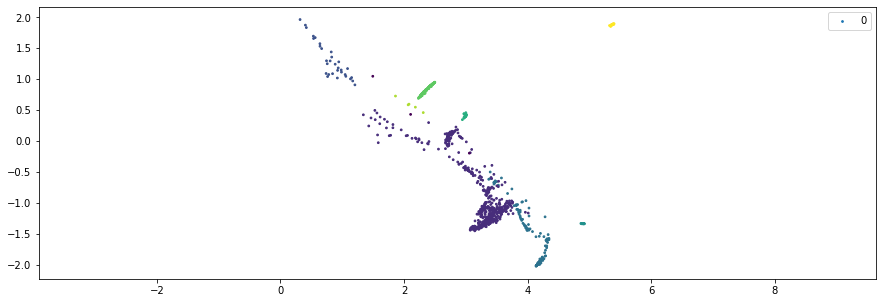

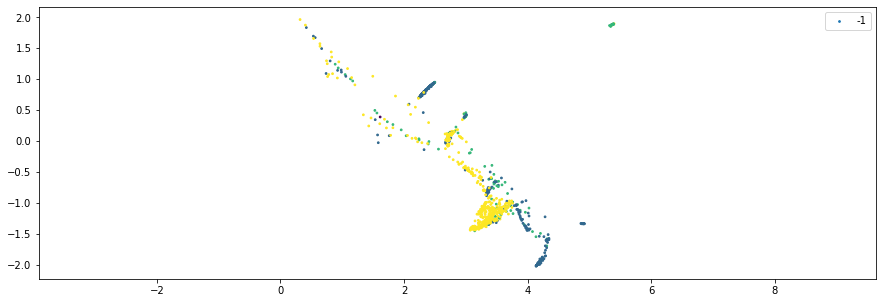

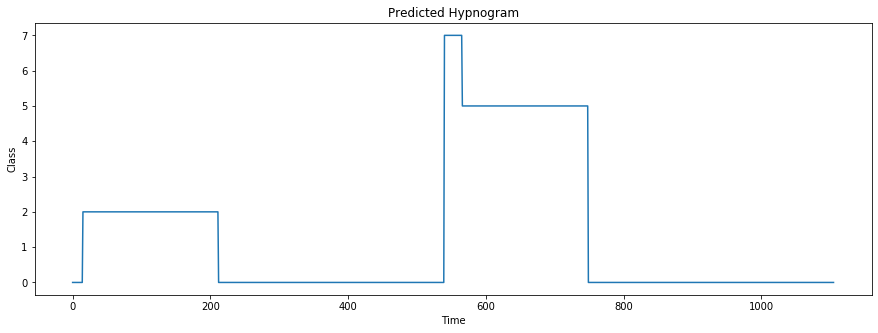

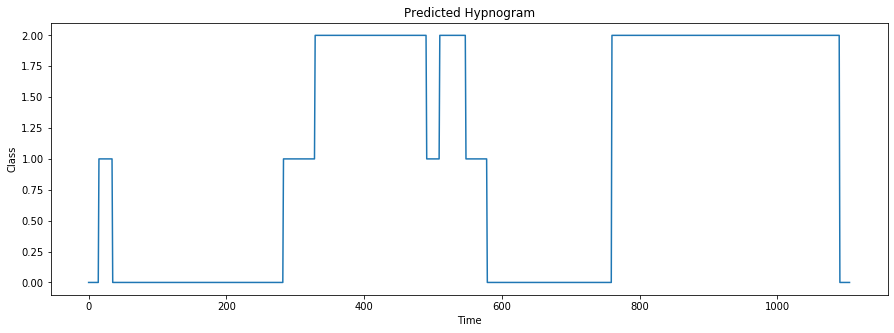

In [148]:
from sklearn.metrics import adjusted_rand_score
clf = sleep_clustering()                       
clf.plot_projection(test_3,test_4.labels_)
clf.plot_projection(test_3,y_test[:,0])
clf.plot_hypnogram(test_4.labels_)
clf.plot_hypnogram(y_test)
print('Score = '+str(adjusted_rand_score(y_test[:,0],test_4.labels_)))